In [182]:
import pandas as pd
import numpy as np
import os
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import plotly.figure_factory as ff
import plotly, geopandas, shapely
import plotly.io as pio

pio.renderers

# Navigate
os.getcwd()

'/Users/sarasharifzadeh/anaconda3/APROJECTS/projectfiles/ev'

### The Datasets

#### EV Charging  Data - CA Counties
I got this dataset from California Energy Commission (CEC), which was obtained from the Alternative Fuels Data Center Station Locator (AFDC), managed by the National Renewable Energy Laboratory (NREL). Reporters of public charging data include: .... 

`Public`: Charging data must be reported to the NREL by station operators or developers. Public charging data includes


`Private` :Charger counts are obtained from voluntary surveys issued by the CEC, which are sent to Electric Vehicle Service Providers (EVSP) & Non-EVSPs. Shared private chargers include: workplaces, multi-family housing, fleets, other non-public venues.


**citation:** California Energy Commission (2023). Electric Vehicle Chargers in California. Data last updated [09/16/2023]. Retrieved [11/19/2023] from https://www.energy.ca.gov/zevstats


#### FIPS
Every US state and county has an assigned ID regulated by the US Federal Government under the term FIPS (Federal Information Processing Standards) codes.

`FIPS`: a state FIPS code (eg. 06 for California) with a county FIPS code of the state (eg. 059 for Orange county) and this new state-county FIPS code (06059) uniquely refers to the specified state and county.
**citation:** https://github.com/kjhealy/fips-codes/blob/master/county_fips_master.csv


#### Additional Data: 

`Population` per County - US Census data for estimates of CA County populations in the year 2021 to determine the "best" counties for EV charging by chargers per 100K people. 


### Objective

In 2021, the Bipartisan group announced a large investment in infrastructure includingm $7.5 billion to build out a national network of EV Chargers. 

source: https://www.whitehouse.gov/briefing-room/statements-releases/2021/07/28/fact-sheet-historic-bipartisan-infrastructure-deal/

My goal is to analyze charging data across counties in California across 2021 to make informed decisions about charging trends & choose the best locations for future chargers. 


In [17]:
os.getcwd()

new_path = '/Users/sarasharifzadeh/anaconda3/APROJECTS/projectfiles/ev/ev2021'
os.chdir(new_path)

### EDA

In [18]:
# the data: quarter1 2021, quarter 2 2021... 
# goal: all quarters for a year in one df with labels for which quarter

#2021 - put all quarters into one df / csv

# ev21 = pd.DataFrame([])

# #read all CSV files and append them to df
# for root, dirs, files in os.walk("."):
#     for name in files:
#         ev_temp = pd.read_csv(name)
#         ev_temp["Quarter"] = name
#         ev21 = pd.concat([ev21,ev_temp])

# # #Save df to a CSV file
# ev21.to_csv('ev2021.csv')


# # #2022
# # ev22 = pd.DataFrame([])

# # #read all CSV files and append them to df
# # for root, dirs, files in os.walk("."):
# #     for name in files:
# #         ev_temp = pd.read_csv(name)
# #         ev_temp["Quarter"] = name
# #         ev22 = pd.concat([ev22,ev_temp])

# # # #Save df to a CSV file
# # ev22.to_csv('ev2022.csv')


ev21 = pd.read_csv("ev2021.csv")
ev21 = ev21.drop(columns=["Unnamed: 0"])

#changing path
new_path = '/Users/sarasharifzadeh/anaconda3/APROJECTS/projectfiles/ev/ev2022'
os.chdir(new_path)


ev22 = pd.read_csv("ev2022.csv")
ev22 = ev22.drop(columns=["Unnamed: 0"])
ev22
ev21.shape, ev22.shape

((240, 9), (240, 9))

In [19]:
import re
#cleaning the Quarter with regex 
    #currently "q1_22.csv" goal: q1
#https://regex101.com

pattern21 = '(\d\d\d\d.\w\w\w)'
text = 'q12021.csv'

ev21["Quarter"] = ev21["Quarter"].str.replace(pattern21, "", regex=True)
ev21


pattern22 = '(\w\d\d.\w\w\w)'
text = "q3_22.csv"

ev22["Quarter"] = ev22["Quarter"].str.replace(pattern22, "", regex=True)
ev22


ev21
# re.sub(pattern21, '', text) 

,County,Public Level 1,Shared Private Level 1,Public Level 2,Shared Private Level 2,Public DC Fast,Shared Private DC Fast,Total,Quarter
0,Alameda,6,70,1671,1583,332,35,3697,q4
1,Alpine,0,0,14,0,0,0,14,q4
2,Amador,0,0,25,6,8,0,39,q4
3,Butte,6,0,41,23,24,0,94,q4
4,Calaveras,0,2,7,0,12,0,21,q4
...,...,...,...,...,...,...,...,...,...
235,Unknown,0,0,0,11,0,0,11,q1
236,Ventura,6,0,387,312,121,19,845,q1
237,Yolo,12,0,156,130,26,0,324,q1
238,Yuba,0,0,9,7,0,0,16,q1


In [20]:
#correct number of County names - 1 per quarter 

ev22 = ev22.sort_values("Quarter")
ev21 = ev21.sort_values("Quarter")

ev21[ev21["County"] == "Alameda"] #checked

#ev22[ev22["County"] == "Alameda"] #checked

,County,Public Level 1,Shared Private Level 1,Public Level 2,Shared Private Level 2,Public DC Fast,Shared Private DC Fast,Total,Quarter
180,Alameda,14,14,1519,1472,296,38,3353,q1
60,Alameda,14,63,1633,1497,310,43,3560,q2
120,Alameda,14,66,1633,1554,315,43,3625,q3
0,Alameda,6,70,1671,1583,332,35,3697,q4


#### Lets Visualize Total EV Chargers per County -- FIPS data

I need to import FIPS Data to map State & County Codes for visualization

In [21]:
#Visualing CA chargers 

#need fIPS
new_path = '/Users/sarasharifzadeh/anaconda3/APROJECTS/projectfiles/ev'
os.chdir(new_path)

#fips = pd.read_csv("county_fips_master.csv")

#ENCODING ERROR
import chardet

with open('county_fips_master.csv', 'rb') as f:
    result = chardet.detect(f.read())

fips = pd.read_csv('county_fips_master.csv', encoding=result['encoding'])
CAfips = fips[fips['state_abbr']== 'CA']
CAfips = CAfips[["fips", "county_name"]]

CAfips["county_name"] = CAfips["county_name"].str.replace(" County", "")
CAfips.head()

,fips,county_name
187,6001,Alameda
188,6003,Alpine
189,6005,Amador
190,6007,Butte
191,6009,Calaveras


In [22]:
ev21["County"] = ev21["County"].astype(str)
CAfips["county_name"] = CAfips["county_name"].astype(str)

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [23]:

# values = mapev21['Total'].tolist()
# fips = mapev21['fips'].tolist()
# # # #endpts = np.arange(0, 21100, 2000)
# # # #endpts = [0,  2000,  4000,  6000,  8000, 10000, 12000, 14000, 16000,
# # #        18000, 21000]
# # #endpts = list(np.linspace(0, 21100, num=10))
# # # endpts = list(np.mgrid[min(values):max(values):16j])
# endpts = [1, 50, 100, 250, 500, 1000, 2000, 5000, 10000, 15000, 20000]

# colorscale = ["#f7fbff","#ebf3fb","#deebf7","#d2e3f3","#c6dbef","#b3d2e9","#9ecae1",
#               "#85bcdb","#6baed6","#57a0ce","#4292c6","#3082be","#2171b5","#1361a9",
#               "#08519c","#0b4083","#08306b"]

# fig = ff.create_choropleth(
#     fips=fips, values=values, scope=['California'], show_state_data=True,
#     colorscale=colorscale, round_legend_values=True,
#     binning_endpoints=endpts,
#     plot_bgcolor='rgb(229,229,229)',
#     paper_bgcolor='rgb(229,229,229)', 
#     legend_title='Total Chargers by County',
#     county_outline={'color': 'rgb(255,255,255)', 'width': 0.5},
#     title_text = 'Total EV Chargers per CA County',
#     exponent_format=True,
# )
# fig.layout.template = None

# fig.show(renderer="svg")

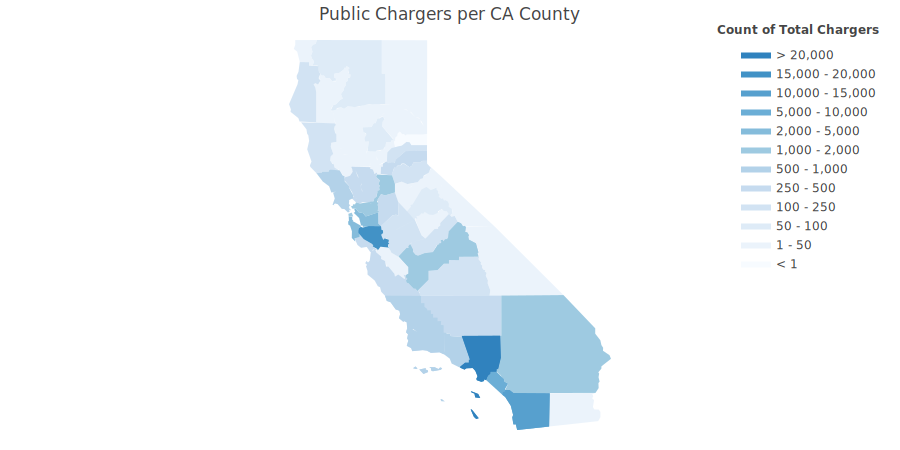

In [24]:
mapev21 = ev21.merge(CAfips, left_on="County", right_on="county_name", how='inner')
mapev21

# NOTE - the data is too uneven to use uniform bins, I intentionally used non-uniform bins

colorscale = ["#f7fbff", "#ebf3fb", "#deebf7", "#d2e3f3", "#c6dbef", "#b3d2e9", "#9ecae1",
    "#85bcdb", "#6baed6", "#57a0ce", "#4292c6", "#3082be", "#2171b5", "#1361a9",
    "#08519c", "#0b4083", "#08306b"
]

#np.logspace(np.log10(0.1),np.log10(1.0), 50)

#endpts = list(np.mgrid[min(values):max(values):16j])
endpts = [1, 50, 100, 250, 500, 1000, 2000, 5000, 10000, 15000, 20000]
values = mapev21['Total'].tolist()
fips = mapev21['fips'].tolist()


fig = ff.create_choropleth(
    fips=fips, values=values, scope=['CA'],
    binning_endpoints=endpts, 
    colorscale=colorscale,
    show_state_data=False,
    show_hover=True,
    asp = 2.9,
    title_text = 'Public Chargers per CA County',
    legend_title = 'Count of Total Chargers'
)
fig.layout.template = None
fig.show(renderer="svg")

**NOTE:** the data is extremely variable. I intentionally used non-uniform bins in this visualization only to aid my understanding. 

## Analysis - Total v. Public v. Private v. DC Fast



### The 5 Counties with the Most EV Chargers in 2021


In [49]:
ev21.groupby("County").sum().sort_values("Total", ascending=False).iloc[1:6, :]#[ev21["County"] != 'Total']

,Public Level 1,Shared Private Level 1,Public Level 2,Shared Private Level 2,Public DC Fast,Shared Private DC Fast,Total,Quarter
County,,,,,,,,
Los Angeles,130,487,28151,48041,3615,475,80899,q1q2q3q4
Santa Clara,23,244,14508,46805,2164,349,64093,q1q2q3q4
San Diego,8,42,7740,22102,1337,202,31431,q1q2q3q4
Orange,31,0,10288,9783,1992,134,22228,q1q2q3q4
San Mateo,8,124,7931,8490,1041,147,17741,q1q2q3q4


### The 5 Counties with the most Public Chargers

In [50]:
public21.groupby("County").sum().sort_values("Total", ascending=False).iloc[1:6, :]

,Public Level 1,Public Level 2,Public DC Fast,Total
County,,,,
Los Angeles,130,28151,3615,31896
Santa Clara,23,14508,2164,16695
Orange,31,10288,1992,12311
San Diego,8,7740,1337,9085
San Mateo,8,7931,1041,8980


### The 5 Counties with the Most Private Chargers:

In [51]:
priv21 = ev21[["County", "Shared Private Level 1", "Shared Private Level 2", "Shared Private DC Fast"]]#.sum()
priv21["Total"] =  priv21["Shared Private Level 1"] + priv21["Shared Private Level 2"] + priv21["Shared Private DC Fast"]
priv21

priv21.groupby("County").sum().sort_values("Total", ascending=False).iloc[1:6, :]

,Shared Private Level 1,Shared Private Level 2,Shared Private DC Fast,Total
County,,,,
Los Angeles,487,48041,475,49003
Santa Clara,244,46805,349,47398
San Diego,42,22102,202,22346
Orange,0,9783,134,9917
San Mateo,124,8490,147,8761


### Chargers By Population - Which counties do not have enough chargers?

In [93]:
#need populations
new_path = '/Users/sarasharifzadeh/anaconda3/APROJECTS/projectfiles/ev'
os.chdir(new_path)


pop = pd.read_csv("capop.csv")
pop = pop.rename(columns={"California": "county", "2021": "population"})
pop
pat = "[^\w ]"
pop["county"] = pop["county"].str.replace(pat, "", regex=True)
pop
popmap21 = mapev21.merge(pop, left_on="County", right_on="county", how="inner")
popmap21
popmap21[popmap21["County"]== "Los Angeles"]

popmap21["population"] = popmap21["population"].apply(lambda a: int(a.replace(',', '')))

popmap21
popmap21["prop per"] = popmap21["population"].astype(int) / popmap21["Total"].astype(int)
min(popmap21["prop per"]), max(popmap21["prop per"])

popmap21.sort_values("population", ascending=False).head()

,County,Public Level 1,Shared Private Level 1,Public Level 2,Shared Private Level 2,Public DC Fast,Shared Private DC Fast,Total,Quarter,fips,county_name,county,population,prop per
33,Los Angeles,33,147,7087,11954,842,130,20193,q2,6037,Los Angeles,Los Angeles,9811842,485.903135
35,Los Angeles,31,147,7380,12252,1042,98,20950,q4,6037,Los Angeles,Los Angeles,9811842,468.345680
32,Los Angeles,33,46,6560,11694,787,116,19236,q1,6037,Los Angeles,Los Angeles,9811842,510.077043
34,Los Angeles,33,147,7124,12141,944,131,20520,q3,6037,Los Angeles,Los Angeles,9811842,478.159942
210,San Diego,2,17,1938,4901,364,56,7278,q3,6073,San Diego,San Diego,3274954,449.979940


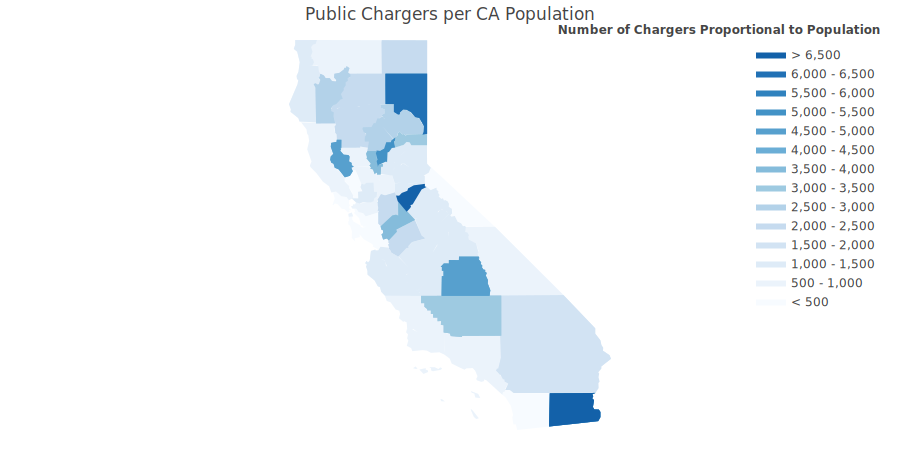

In [90]:

colorscale = ["#f7fbff", "#ebf3fb", "#deebf7", "#d2e3f3", "#c6dbef", "#b3d2e9", "#9ecae1",
    "#85bcdb", "#6baed6", "#57a0ce", "#4292c6", "#3082be", "#2171b5", "#1361a9",
    "#08519c", "#0b4083", "#08306b"
]

#np.logspace(np.log10(0.1),np.log10(1.0), 50)

#endpts = list(np.mgrid[min(values):max(values):16j])
endpts = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500]
values = popmap21['prop per'].tolist()
fips = popmap21['fips'].tolist()


fig = ff.create_choropleth(
    fips=fips, values=values, scope=['CA'],
    binning_endpoints=endpts, 
    colorscale=colorscale,
    show_state_data=False,
    show_hover=True,
    asp = 2.9,
    title_text = 'Public Chargers per CA Population',
    legend_title = 'Number of Chargers Proportional to Population'
)
fig.layout.template = None
fig.show(renderer="svg")

In [91]:
#popmap21.sort_values("prop per", ascending = False)
popmap21.groupby("County").max("prop per").sort_values("prop per", ascending=False).iloc[0:5, :]#[ev21["County"]

,Public Level 1,Shared Private Level 1,Public Level 2,Shared Private Level 2,Public DC Fast,Shared Private DC Fast,Total,fips,population,prop per
County,,,,,,,,,,
Imperial,0,0,8,13,12,0,33,6025,179215,6637.592593
Calaveras,0,2,7,0,12,0,21,6009,46219,6602.714286
Lassen,0,1,4,1,8,0,14,6035,31813,6362.600000
Yuba,0,0,25,7,0,0,32,6115,83216,5201.000000
Lake,0,0,14,3,0,0,17,6033,68584,4898.857143


### Basic Analysis

The 5 Counties that seem to be the "best" for EV Charging as determined by the proportion of chargers against the population of the county are: **Imperial, Calvera, Lassen, Yuba, & Lake County**. These counties are more rural with smaller populations. The 5 Counties with the most charger counts across Public, Private & Overall total counts were: **Los Angeles, Santa CLara, San Diego, & San Mateo County.** 

According to the CA Energy Commission, new Zero-Emission Vehicle Sales in CA (2021) accounted for about 12% of all new cars sold, and in 2022 it was 18.8%.

CA needs to account for the new influx of EV's by developing a robust charging infrastructure in order to support consumer confidence and retention in sustainable transportation alternatives.



<center>
<img alt="chargerdem" src="cdemand.png" width="600px;" />
</center>

source: https://www.mckinsey.com/features/mckinsey-center-for-future-mobility/our-insights/can-public-ev-fast-charging-stations-be-profitable-in-the-united-states